DATA PREPARATION:

This jupyter notebook is created to do quick modifications to the collected data- images and associated csv file for each printed specimen. The following sets of code ultimatelyy creates the final dataset of over 15000 images in one folder, and an associated csv file with the metadata. The following functions here are involved in creating the dataset. The functions have been kept as separate code blocks as there were multiple steps involved- and required adjustments/ verification before proceeding to the next step.


1. INCREASE IMAGE BRIGHTNESS, RENAME THE IMAGE AND ASSOCIATED img_path in the csv AND SAVE IN DIRECTORY (NOTE THE PROTOTYPE NAMES CAREFULLY)

2. Path of the image changed in the csv for workability

3. Some Images were filtered - start and end of printing; and ones that donot have a coresponding data row in the csv file

In [ ]:
#Following function to process images is used individually for set of images for each sample- thus naming them serially using the sample id.

import os
import pandas as pd
from shutil import move
from PIL import Image, ImageEnhance

# Function to increase brightness, rename images, and update CSV
def process_images_and_update_csv(image_folder, csv_path, output_folder, new_csv_path, brightness_factor=1.5):
    # Load the CSV file
    df = pd.read_csv(csv_path)

    # Keep the column names intact, remove the next 4 rows (i.e., the first four images) #CHANGEE BASED ON HOW MANY TO FILTER
    df = df.drop(df.index[0:6]).reset_index(drop=True)

    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through the remaining images, enhance brightness, rename, and update CSV
    for index, row in df.iterrows():
        # Skip the first row as it's the header
        
        old_image_path = os.path.join(image_folder, os.path.basename(row['photo_location']))
        new_image_name = f"C5c_{index:03d}.jpg"  #for serial numbering of the images of sample named 'c5c'
        new_image_path = os.path.join(output_folder, new_image_name)

        # Open, increase brightness, and save the image
        if os.path.exists(old_image_path):
            with Image.open(old_image_path) as img:
                enhancer = ImageEnhance.Brightness(img)
                img_bright = enhancer.enhance(brightness_factor)
                img_bright.save(new_image_path)

        # Update the photo_location in the dataframe
        df.at[index, 'photo_location'] = f"dataset_filtered/{new_image_name}"

    # Save the updated CSV to the new path
    df.to_csv(new_csv_path, index=False)

    print(f"Images processed, renamed, and CSV updated. New CSV saved at {new_csv_path}")

# USAGE
image_folder = 'RAW IMAGE INPUT FOLDER'
csv_path = 'RAW CSV FILE'
output_folder = 'OUTPUT FOLDER FOR THE IMAGES'
new_csv_path = 'ENTER CSV PATH'
brightness_factor = 1.5  # Adjust brightness factor per specimen depending on lighting conditions in the raw image- might be different for specimen printed on each day

process_images_and_update_csv(image_folder, csv_path, output_folder, new_csv_path, brightness_factor)



Images processed, renamed, and CSV updated. New CSV saved at E:\MSC\CORE\MudTracker3D\mudtracker3d_dataset\C5c.csv


4. Locate the nozzle tip centre pixel using a photo editing tool. -This was done every time a new set of images were processed as the camera was not permanently installed throughout the weeks of data colloection.

5. Cropping the image to 1280x720px using the nozzle x,y as centre- this reduces the size of the dataset overall.

In [ ]:
#Process and overwrite the (renamed) images from above in the folder.

import os
from PIL import Image, ImageEnhance

# Function to crop and resize images using the center point as the crop center
def crop_and_resize_images(input_folder, target_resolution=(1280, 720), center_point=(2291, 1039)):
    # Iterate over all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            file_path = os.path.join(input_folder, filename)

            # Open the image
            with Image.open(file_path) as img:
 
                #BRIGHTNESS
                #brightness_factor=1.7
                #enhancer = ImageEnhance.Brightness(img)
                #img = enhancer.enhance(brightness_factor)
 
                # Original resolution
                width, height = img.size

                # Define the cropping box around the center point (x, y)
                target_width, target_height = target_resolution

                # Calculate the left, top, right, and bottom based on the center point
                left = center_point[0] - target_width // 2
                top = center_point[1] - target_height // 2
                right = center_point[0] + target_width // 2
                bottom = center_point[1] + target_height // 2

                # Ensure the crop box stays within the image boundaries
                if left < 0:
                    left = 0
                    right = target_width
                if right > width:
                    right = width
                    left = width - target_width
                if top < 0:
                    top = 0
                    bottom = target_height
                if bottom > height:
                    bottom = height
                    top = height - target_height

                # Crop the image
                cropped_img = img.crop((left, top, right, bottom))

                # Resize the cropped image to the target resolution
                resized_img = cropped_img.resize(target_resolution, Image.Resampling.LANCZOS)


                # Save and overwrite the original image
                resized_img.save(file_path)



                print(f"Processed and overwritten: {filename}")

# Define paths and center point
input_folder = 'ENTER PATH OF IMAGE FOLDER'
center_point = (1163, 735)  # x, y center point in pixels

# Process images
crop_and_resize_images(input_folder, target_resolution=(1280, 720), center_point=center_point)


6. MODIFYING THE CSV FILE: Turn G-code into readable data

-G-code string to Data-Parameters: x, y, z, extrusion_e, and speed_f

-Append nozzle_tip_x and nozzle_tip_y to the csv by locating the nozzle tip of an image manually on a photo editing tool.

-Append extrusion amount and layer height used for slicing the object in Rhino


In [ ]:
import pandas as pd 
import re

# Function to extract G-code data and modify the CSV
def extract_gcode_and_modify_csv(input_csv, output_csv):
    # Load the CSV file
    df = pd.read_csv(input_csv)

    # Rename 'photo_location' column to 'img_path'
    df.rename(columns={'photo_location': 'img_path'}, inplace=True)

    # Regular expression pattern to extract x, y, z, e, and f values
    pattern = r'G\d+\sX(-?\d*\.?\d+)\sY(-?\d*\.?\d+)?\sZ(-?\d*\.?\d+)?\sE(-?\d*\.?\d+)?\sF(\d+)?'

    # Create new columns for x, y, z, extrusion_e, and speed_f
    df[['x', 'y', 'z', 'extrusion_e', 'speed_f']] = df['gcode'].str.extract(pattern)

    # Convert the extracted values to numeric type
    df['x'] = pd.to_numeric(df['x'], errors='coerce')
    df['y'] = pd.to_numeric(df['y'], errors='coerce')
    df['z'] = pd.to_numeric(df['z'], errors='coerce')
    df['extrusion_e'] = pd.to_numeric(df['extrusion_e'], errors='coerce')
    df['speed_f'] = pd.to_numeric(df['speed_f'], errors='coerce')

    # Append nozzle_tip_x and nozzle_tip_y columns with constant values   CHANGE
    df['nozzle_tip_x'] = 638
    df['nozzle_tip_y'] = 357

    df['extrusion_class'] = 2
    df['layer_height_class'] = 2

    # Calculate the layer height as the difference in 'z' between consecutive rows
    df['layer_height'] = 1.2   #CHANGE

    # Append the extrusion_rate column with a constant value of 0.2 for all rows
    df['extrusion_rate'] = 1.0  #CHANGE

    # Reorder the columns so that 'extrusion_rate' comes right after 'extrusion_e'
    columns_order = ['img_path', 'timestamp', 'x', 'y', 'z', 'layer_height', 'extrusion_e', 'extrusion_rate', 
                     'speed_f', 'nozzle_tip_x', 'nozzle_tip_y', 'layer_height_class', 'extrusion_class']

    # Reorder the DataFrame with the new column order
    df = df[columns_order]

    # Drop the original 'gcode' column
    df = df.drop(columns=['gcode'], errors='ignore')  # 'gcode' might already be dropped in case of re-runs

    # Save the modified DataFrame to a new CSV file
    df.to_csv(output_csv, index=False)

    print(f"CSV file updated and saved to {output_csv}")

# Usage
input_csv = 'PATH TO THE INPUT CSV FILE SAVED FROM ABOVE CODE BLOCK'  
output_csv = 'PATH TO OUTPUT CSV'  

extract_gcode_and_modify_csv(input_csv, output_csv)


7. JOIN ALL CSVS

(PROCEED AFTER THE ABOVE FUNCTIONS ARE RUN FOR SET OF IMAGES FOR EACH SPECIMEN IN THE DATASET.)

-Separate csvs joined into one to create the final dataset.




In [ ]:
import os
import pandas as pd

# Specify the folder containing the CSV files
folder_path = 'PATH TO THE FOLDER WITH ALL MODIFIED CSV FILES FROM ABOVE'
output_file = 'PATH TO OUTPUT CSV'

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through all the CSV files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        dataframes.append(df)

# Concatenate all DataFrames into one
merged_df = pd.concat(dataframes, ignore_index=True)

# Save the merged DataFrame to a CSV file
merged_df.to_csv(output_file, index=False)

print(f"All files merged and saved to {output_file}")

All files merged and saved to E:\MSC\CORE\MudTracker3D\mudtracker3d_dataset\modified_csvs\final_dataset_full_filtered.csv


7.1 Check if images are missing- as they are always called be the path in csv.

In [ ]:
#CHECK MISSING IMAGES

import os
import pandas as pd

# Specify the paths
csv_file = 'PATH TO MERGED CSV FILE ABOVE'
image_folder = 'PATH TO IMAGES'

# Read the CSV file
df = pd.read_csv(csv_file)

# Get the list of image paths from the CSV
image_paths_in_csv = df['img_path'].tolist()

# Get the list of image files present in the folder
images_in_folder = set(os.listdir(image_folder))

# Extract image names (e.g., 'A1a_000.jpg') from the paths
image_names_in_csv = [os.path.basename(path) for path in image_paths_in_csv]

# Find images listed in the CSV but not present in the folder
missing_images = [img for img in image_names_in_csv if img not in images_in_folder]

# Print or visualize the missing image names
if missing_images:
    print("The following images are listed in the CSV but not found in the folder:")
    for img in missing_images:
        print(img)
else:
    print("All images listed in the CSV are present in the folder.")


All images listed in the CSV are present in the folder.


8. Once we have a whole dataset csv file, append the parameter labels - considering two specimen standards (A1-LH 0.6,E 0.2) and (B1-LH 0.9,E 0.2)

-Append layer height labels first 
-decide extrusion labels based on the layer height

In [ ]:
#Modify csv based on standards
#A1 and B1 standard

import pandas as pd

# Load the CSV file
csv_file = 'PATH TO MERGED CSV FILE ABOVE'
df = pd.read_csv(csv_file)

# Define the function for classifying 'layer_height_class'
def classify_layer_height(layer_height):
    if layer_height == 0.6:
        return 1
    elif layer_height == 0.9:
        return 1
    elif layer_height > 0.9:
        return 2
    else:
        # Calculate the mid-point
        mid_point = (0.6 + 0.9) / 2
        if layer_height > mid_point:
            return 0  # Towards 0.9
        else:
            return 2  # Towards 0.6

# Define the function for classifying 'extrusion_class'
def classify_extrusion_rate(layer_height, extrusion_rate, layer_height_class):
    if layer_height == 0.6:
        if extrusion_rate == 0.2:
            return 1
        elif extrusion_rate < 0.2:
            return 0
        else:
            return 2
    elif layer_height == 0.9:
        if extrusion_rate == 0.2:
            return 1
        elif extrusion_rate < 0.2:
            return 0
        else:
            return 2
    elif layer_height_class == 0:  # Towards 0.9
        if extrusion_rate < 0.2:
            return 0
        elif extrusion_rate == 0.2:
            return 1
        else:
            return 2
    elif layer_height_class == 2:  # Towards 0.6
        if layer_height > 0.9:
            if extrusion_rate == 0.2:
                return 1
            elif extrusion_rate < 0.2:
                return 0
            else:
                return 2
        else:
            if extrusion_rate < 0.2:
                return 0
            elif extrusion_rate == 0.2:
                return 1
            else:
                return 2

# Apply the classification for 'layer_height_class'
df['layer_height_class'] = df['layer_height'].apply(classify_layer_height)

# Apply the classification for 'extrusion_class' using the already classified 'layer_height_class'
df['extrusion_class'] = df.apply(lambda row: classify_extrusion_rate(row['layer_height'], row['extrusion_rate'], row['layer_height_class']), axis=1)

# Save the modified CSV to a new file
df.to_csv('PATH TO FINAL CSV OUTPUT', index=False)

print("The CSV file has been modified and saved as 'modified_output.csv'.")



The CSV file has been modified and saved as 'modified_output.csv'.


VISUALIZATION:

Following codes are used to vidualize the data distribution in the dataset. This was further used to understand what weights to use for sampling for dataloaders (train,test and validation)

C:\Users\Swornava\AppData\Local\Temp\ipykernel_26408\4082349500.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='class_combination', y='count', data=comb_counts, palette='viridis')


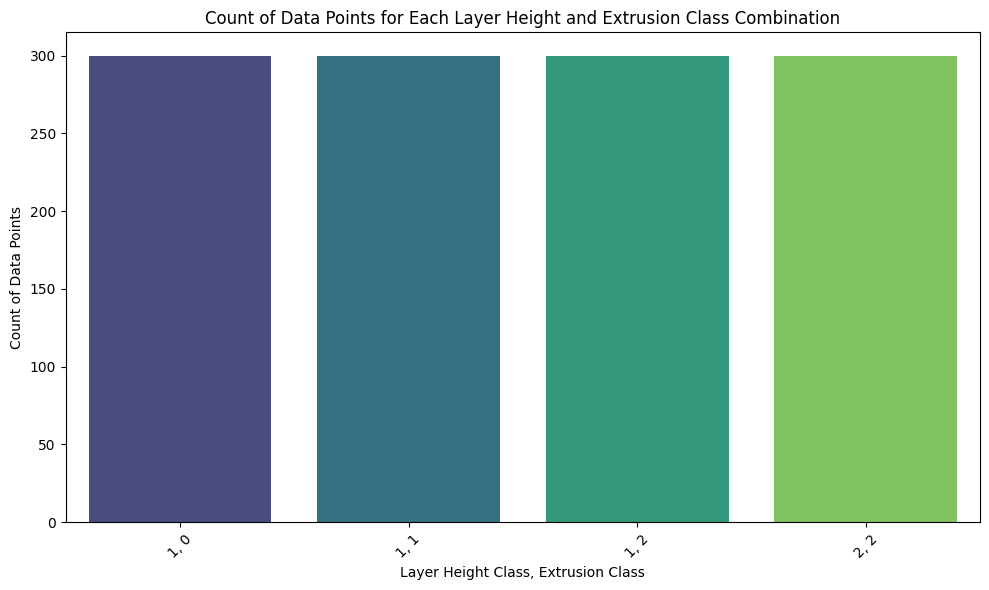

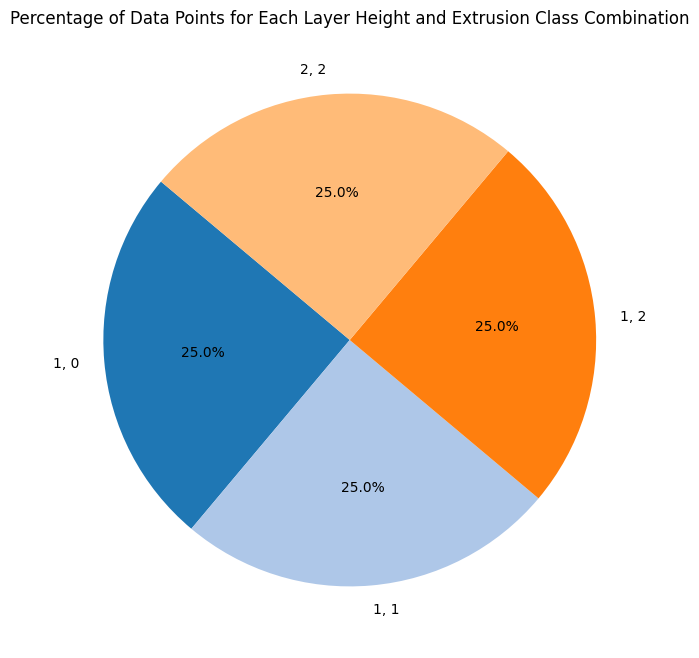

In [ ]:
#Visualise the labels
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = 'PATH TO FINAL DATASET CSV FILE'
data = pd.read_csv(file_path)

# Create a new column combining layer_height_class and extrusion_class for unique identifiers
data['class_combination'] = data['layer_height_class'].astype(str) + ", " + data['extrusion_class'].astype(str)

# Group by the combination and count occurrences
comb_counts = data['class_combination'].value_counts().reset_index()
comb_counts.columns = ['class_combination', 'count']

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='class_combination', y='count', data=comb_counts, palette='viridis')
plt.title('Count of Data Points for Each Layer Height and Extrusion Class Combination')
plt.xlabel('Layer Height Class, Extrusion Class')
plt.ylabel('Count of Data Points')
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

# Define a color palette with unique colors
colors = sns.color_palette('tab20', len(comb_counts))

# Plot a pie chart with unique colors
plt.figure(figsize=(8, 8))
plt.pie(comb_counts['count'], labels=comb_counts['class_combination'], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Percentage of Data Points for Each Layer Height and Extrusion Class Combination')
plt.show()




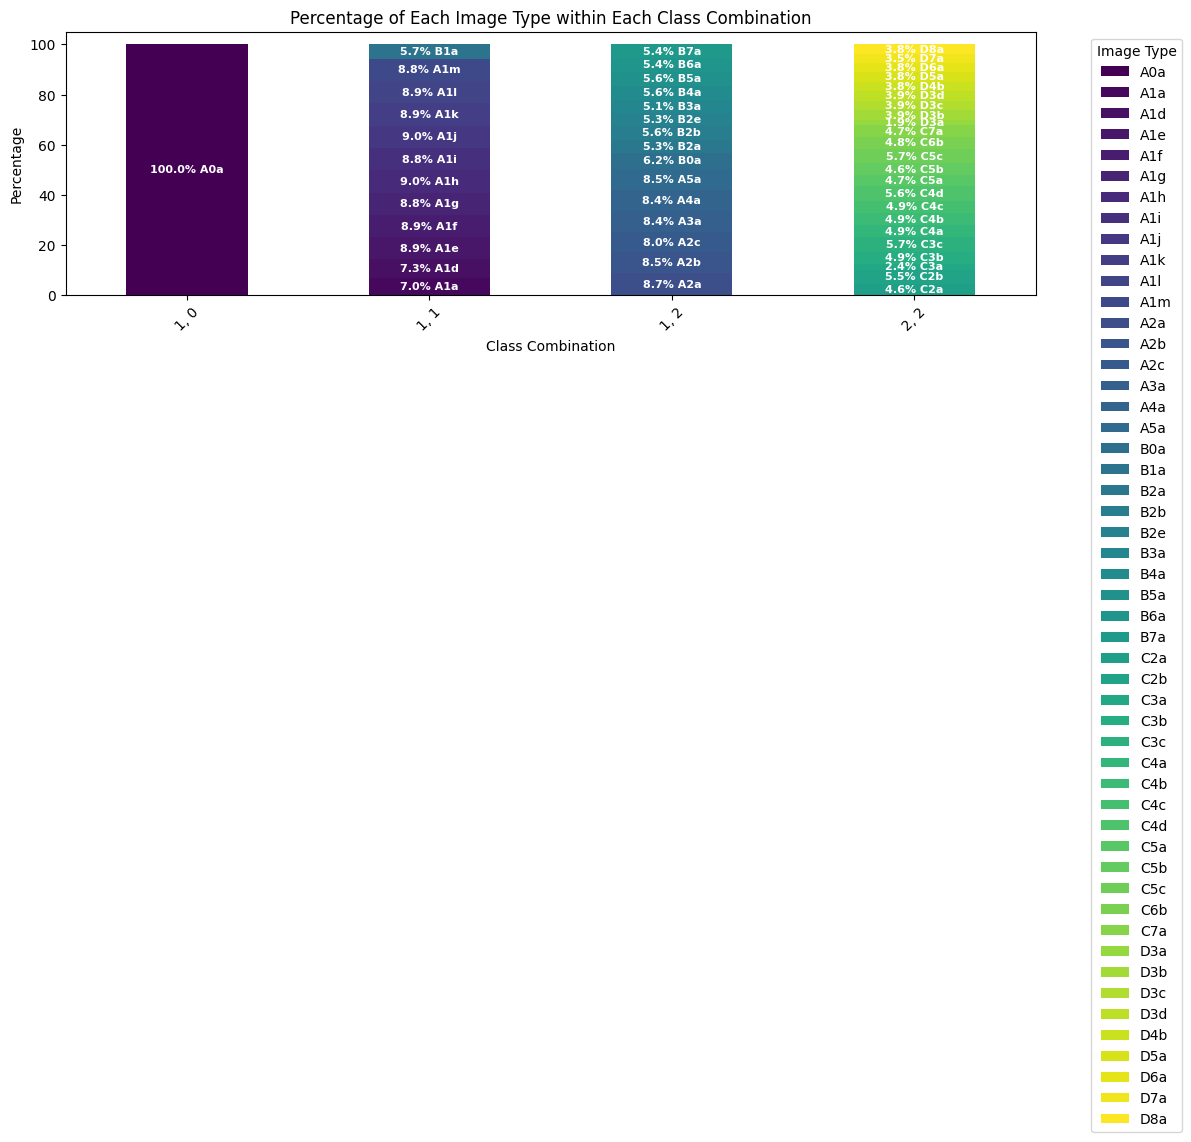

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'PATH TO FINAL DATASET CSV FILE'
data = pd.read_csv(file_path)

# Create 'class_combination' column
data['class_combination'] = data['layer_height_class'].astype(str) + ", " + data['extrusion_class'].astype(str)

# Extract the image type (e.g., A0a, A1a) from img_path before the underscore
data['img_type'] = data['img_path'].str.split('/').str[-1].str.split('_').str[0]

# Count occurrences of each img_type within each class_combination
grouped_data = data.groupby(['class_combination', 'img_type']).size().unstack(fill_value=0)

# Normalize counts within each class_combination to get percentages
grouped_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100  # Convert to percentage

# Plot a stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))
grouped_data.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')
plt.title('Percentage of Each Image Type within Each Class Combination')
plt.xlabel('Class Combination')
plt.ylabel('Percentage')
plt.xticks(rotation=45)

# Annotate each bar segment with the percentage value
for idx, class_combination in enumerate(grouped_data.index):
    cumulative = 0
    for img_type, percent in grouped_data.loc[class_combination].items():
        if percent > 0:  # Only label segments with non-zero values
            ax.text(
                idx, cumulative + percent / 2,  # Position text at the middle of each segment
                f'{percent:.1f}% {img_type}', ha='center', va='center', color='white', fontsize=8, weight='bold'
            )
        cumulative += percent

# Move legend outside the plot
plt.legend(title='Image Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()




REMOVING TEST SAMPLES FROM THE FINAL DATASET:

We removed around 90 images from the overall dataset for manual testing of the machine learning model. These images were not in any of the train, test/ validation sets and were kept separate to be used as 'unseen new data' for testing purpose only.

In [ ]:
import os
import pandas as pd
import shutil
import random

# Define paths
original_csv_path = 'PATH TO FINAL DATASET CSV FILE'
source_folder = 'PATH TO IMAGE FOLDER'
destination_folder = 'PATH TO IMAGE DESTINATION FOLDER'

# Create destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Load the CSV file
df = pd.read_csv(original_csv_path)

# List of required types
required_types = [
    "A0a", "A1a", "A1d", "A1e", "A1f", "A1g", "A1h", "A1i", "A1j", "A1k", 
    "A1l", "A1m", "A2a", "A2b", "A2c", "A3a", "A4a", "A5a", "B0a", "B1a", "B2a", "B3a", "B4a", "B5a", "B6a", "B7a", 
    "C2a", "C3a", "C3b", "C3c", "C4a", "C4b", "C4c", "C4d", "C5a", "C5b", "C5c", "C6b", "C7a", "D3a", "D3b", "D3c", "D4a", "D4b", "D5a", "D6a", "D7a", "D8a"
]

# Filter and move images
removed_df = pd.DataFrame(columns=df.columns)
remaining_df = df.copy()

for img_type in required_types:
    # Filter images of the specific type
    filtered_images = df[df['img_path'].str.contains(f'/{img_type}_')]
    
    # Select 3 random images if available
    if len(filtered_images) >= 30:
        sampled_images = filtered_images.sample(n=30, random_state=1)
        
        # Move each sampled image
        for img_path in sampled_images['img_path']:
            src_path = os.path.join(source_folder, os.path.basename(img_path))
            dst_path = os.path.join(destination_folder, os.path.basename(img_path))
            if os.path.exists(src_path):
                shutil.move(src_path, dst_path)
        
        # Update DataFrames
        removed_df = pd.concat([removed_df, sampled_images])
        remaining_df = remaining_df[~remaining_df['img_path'].isin(sampled_images['img_path'])]

# Save the updated CSV files
removed_csv_path = r'C:\Users\Swornava\Delft University of Technology\Wei Wei - MSc3_CORE_Group 2\Dataset\mudtracker3D_dataset\Test- only A1 data\removed_images.csv'
remaining_csv_path = r'C:\Users\Swornava\Delft University of Technology\Wei Wei - MSc3_CORE_Group 2\Dataset\mudtracker3D_dataset\Test- only A1 data\remaining_images.csv'

removed_df.to_csv(removed_csv_path, index=False)
remaining_df.to_csv(remaining_csv_path, index=False)

print("Images moved and CSV files updated successfully.")
